In [1]:
%matplotlib inline

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import seaborn as sns
import tools

In [3]:
# plt.style.use("coolbeans")
sns.set_style("whitegrid")
mpl.rcParams.update({'font.size': 10})
np.random.seed(123)

In [4]:
DB_PATH = "./data/stationdb.sqlite"
TCR_PATH = "./data/20th_rean_V2.npz"
ERSST_PATH = "./data/ersst.npz"
WESTOFLON = -104
EASTOFLON = -125
WATER_YEAR = {"low": 1925,
              "high": 2011}
WY_RANGE = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, year, meanCFS FROM StationWY 
               WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) 
               GROUP BY stationid, year 
               ORDER BY stationid, year ASC""".format(wy_low = str(WATER_YEAR["low"]), 
                                                      wy_high = str(WATER_YEAR["high"]), 
                                                      seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["year", "stationid"])
conn.close()

In [6]:
raw.unstack(level = -1).to_csv('streamflow_1925.csv')

In [7]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, latgage, longage FROM StationInfo 
               WHERE stationid IN ({seq}) 
               ORDER BY stationid ASC""".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

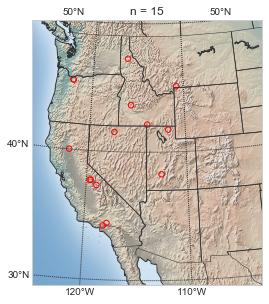

In [8]:
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## KS-Test for non-gamma distributed streamflow

stationid
10263500    0.011485
Name: meanCFS, dtype: float64


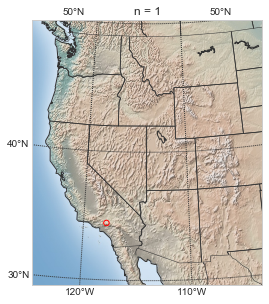

In [9]:
kspvals = raw.groupby(level = 'stationid')['meanCFS'].aggregate(tools.adj_gamma_kstest)
# latlon of gages which do not fit gamma.
print(kspvals[kspvals <= 0.05])
non_gamma = latlon[latlon['stationid'].isin(kspvals[kspvals <= 0.05].index.values)]
out = tools.plot_gagesmap(non_gamma["latgage"].as_matrix(), non_gamma["longage"].as_matrix())

## Test for peak runoff

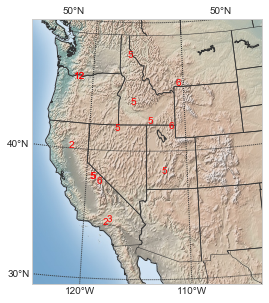

In [10]:
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, year, month, meanCFS FROM StationMonthly 
               WHERE year <= {cal_high} AND year >= {cal_low} AND stationid IN ({seq}) 
               ORDER BY stationid, year, month ASC""".format(cal_low = str(CAL_YEAR["low"]), 
                                                             cal_high = str(CAL_YEAR["high"]), 
                                                             seq = ",".join(["?"] * len(target_stations)))
monthly_flows = pd.read_sql(sql_query, conn, params = target_stations, index_col = ['stationid', 'year', 'month'])
conn.close()
monthly_mean = monthly_flows.groupby(level = ['stationid', 'month']).mean()
# Get month with max flow for each station.
max_month = monthly_mean.groupby(level = 'stationid').idxmax()['meanCFS'].apply(lambda a: a[1])

# Join max months with latlon data.
max_month = latlon.join(max_month, on = 'stationid')

# Plot data on map
fig = plt.figure(figsize = (4, 6))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
m.drawcoastlines(color = "#333333")
m.drawstates(linewidth = 0.7, color = "#333333")
m.drawcountries(color = "#333333")
m.shadedrelief()
parallels = np.arange(0., 81, 10)
m.drawparallels(parallels, labels = [True, False, True, False], color = "#333333")
meridians = np.arange(10., 351., 10)
m.drawmeridians(meridians, labels = [False, True, False, True], color = "#333333")
for r in max_month.iterrows():
    x, y = m(r[1]['longage'], r[1]['latgage'])  # A bit slow. Should do all at once.
    plt.text(x, y, r[1]['meanCFS'], color = 'r')
plt.show()

## Standardize streamflow

In [11]:
parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.spigamma)

## Basic North Test scree plot

In [12]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 10
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

In [13]:
test = pd.DataFrame(pc)
test.columns = ["PC" + str(x + 1) for x in range(examine_modes)]
test['WY'] = WY_RANGE
test.to_csv('pc_1925.csv', index = False)

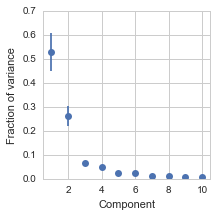

In [14]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [15]:
retain_modes = 2

## PC time series from leading components

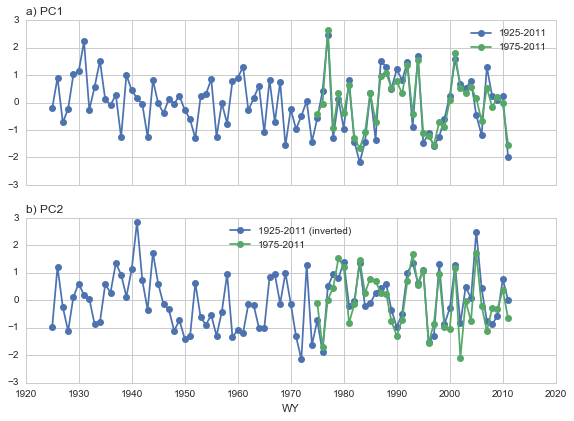

In [16]:
test_1975 = pd.read_csv('pc_1975.csv')
# test_1950 = pd.read_csv('pc_1950.csv')
fig, axes = plt.subplots(figsize = (9.5, 6.5), nrows = 2, ncols = 1, sharex = True, sharey = True)
axes.flat[0].plot(test['WY'], test['PC1'], '-o', label = '1925-2011')
# axes.flat[0].plot(test_1950['WY'], test_1950['PC1'], '-o', label = '1950-2011')
axes.flat[0].plot(test_1975['WY'], test_1975['PC1'], '-o', label = '1975-2011')
axes.flat[0].set_title('a) PC1', loc = 'left')
axes.flat[1].plot(test['WY'], -test['PC2'], '-o', label = '1925-2011 (inverted)')
# axes.flat[1].plot(test_1950['WY'], -test_1950['PC2'], '-o', label = '1950-2011 (inverted)')
axes.flat[1].plot(test_1975['WY'], test_1975['PC2'], '-o', label = '1975-2011')
axes.flat[1].set_title('b) PC2', loc = 'left')
axes.flat[0].legend()
axes.flat[1].legend(loc = 'upper center')
axes.flat[1].set_xlabel('WY')
axes.flat[0].xaxis.set_ticks(np.arange(1920, 2030, 10))
plt.savefig("./plots/s4.eps")

## Leading EOFs mapped as covariance

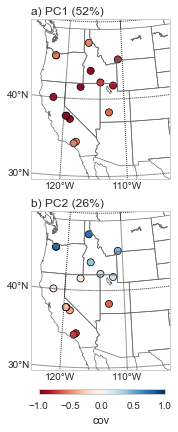

In [17]:
out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes,
                     figure_size = (2.5, 6.5))
plt.savefig("./plots/s1.eps")

## Leading two modes as vectors

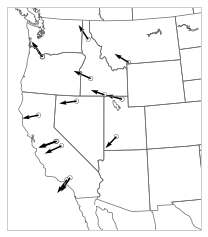

In [18]:
# Linear regression of the first two leading PCs onto the gage time series to get regression coefficients.
rcoef1 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])

out = tools.plot_vectormap(coef1 = rcoef1, coef2 = rcoef2,
                           lat = latlon["latgage"].as_matrix(),
                           lon = latlon["longage"].as_matrix())

# Point correlation maps

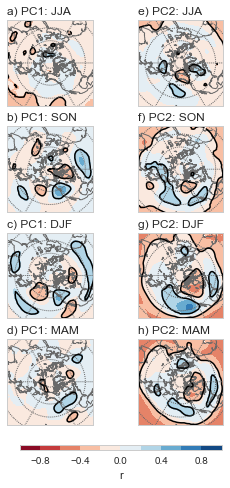

In [19]:
# Plot for figure 2
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
lat = tcr["lat"]
lon = tcr["lon"]
pc = solver.pcs(npcs = 2, pcscaling = 1)
fig = plt.figure(figsize = (4, 7))
divs = np.linspace(-1, 1, 11)
msk = None
world_map = False
alpha=[0.05]

##################################### PC1
i = 0

## JJA
hgts = tcr["data"][3, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(421)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "a) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")

## SON
hgts = tcr["data"][2, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(423)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "b) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(425)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "c) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")

## MAM
hgts = tcr["data"][1, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(427)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "d) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")

##################################### PC 2
i = 1

## JJA

hgts = tcr["data"][3, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(422)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "e) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")



# SON
hgts = tcr["data"][2, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

i = 1
ax = fig.add_subplot(424)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "f) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(426)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "g) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")


## MAM
hgts = tcr["data"][1, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(428)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
title_str = "h) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")


fig.tight_layout()

fig.subplots_adjust(bottom = 0.15)
cax = fig.add_axes([0.17, 0.1, 0.7, 0.01])
cb = plt.colorbar(ctf1, cax = cax, orientation='horizontal')
cb.set_label("r")

plt.savefig("./plots/s5.eps")

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


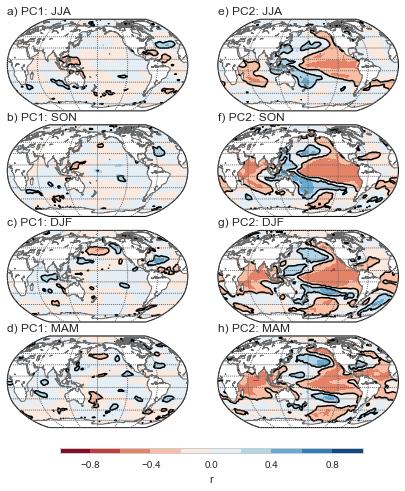

In [20]:
# Plot for figure 3
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
lat = ersst["lat"]
lon = ersst["lon"]
pc = solver.pcs(npcs = 2, pcscaling = 1)
fig = plt.figure(figsize = (6, 7))
divs = np.linspace(-1, 1, 11)
msk = ersst["landmask"]
world_map = True
alpha=[0.05]

##################################### PC1
i = 0

## JJA
sst = ersst["data"][3, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(421)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "PC" + str(i + 1)
# ax.set_title(title_str)
# plt.ylabel("JJA")
title_str = "a) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")


## SON
sst = ersst["data"][2, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(423)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# plt.ylabel("SON")
# title_str = "ASO PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")
title_str = "b) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(425)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# plt.ylabel("DJF")
# title_str = "NDJ PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")
title_str = "c) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")

## MAM
sst = ersst["data"][1, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(427)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# plt.ylabel("MAM")
# title_str = "FMA PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")
title_str = "d) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")

##################################### PC 2
i = 1

## JJA

sst = ersst["data"][3, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(422)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "PC" + str(i + 1)
# ax.set_title(title_str)
title_str = "e) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")


# SON
sst = ersst["data"][2, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

i = 1
ax = fig.add_subplot(424)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "ASO PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")
title_str = "f) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(426)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "NDJ PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")
title_str = "g) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")

## MAM
sst = ersst["data"][1, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(428)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "FMA PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")
title_str = "h) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")

# fig.subplots_adjust(right = 0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

fig.tight_layout()

fig.subplots_adjust(bottom = 0.15)
cax = fig.add_axes([0.17, 0.1, 0.7, 0.01])
cb = plt.colorbar(ctf1, cax = cax, orientation='horizontal')
cb.set_label("r")

# plt.savefig("./plots/fig3.png", dpi = 300)
plt.savefig("./plots/s6.eps")
# plt.show()

# Composite maps

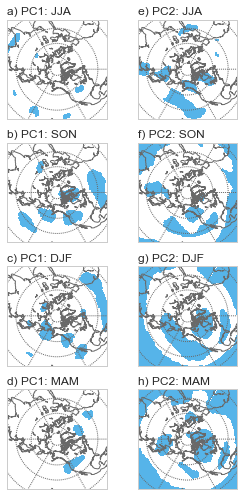

In [21]:
# Plot for figure S6
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
lat = tcr["lat"]
lon = tcr["lon"]
pc = solver.pcs(npcs = 2, pcscaling = 1)
fig = plt.figure(figsize = (4, 7))
msk = None
world_map = False
alpha=[0.05]

##################################### PC1
i = 0

## JJA
hgts = tcr["data"][3, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(421)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "a) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")

## SON
hgts = tcr["data"][2, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(423)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "b) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(425)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "c) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")

## MAM
hgts = tcr["data"][1, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(427)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "d) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")

##################################### PC 2
i = 1

## JJA

hgts = tcr["data"][3, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(422)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "e) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")



# SON
hgts = tcr["data"][2, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(424)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "f) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(426)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "g) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")


## MAM
hgts = tcr["data"][1, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(428)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "h) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")



fig.tight_layout()

# fig.subplots_adjust(bottom = 0.15)

plt.savefig("./plots/s7.eps")

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


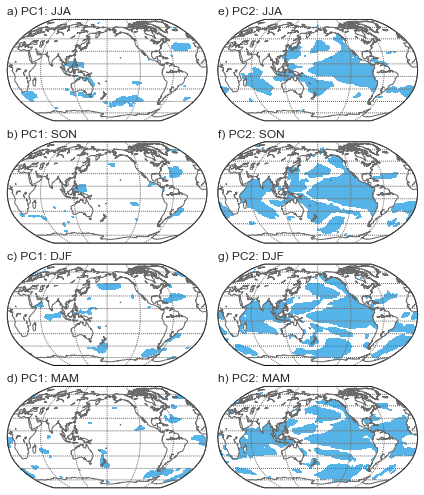

In [22]:
# Plot for figure S7
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
lat = ersst["lat"]
lon = ersst["lon"]
pc = solver.pcs(npcs = 2, pcscaling = 1)
fig = plt.figure(figsize = (6, 7))
divs = np.linspace(-1, 1, 11)
msk = ersst["landmask"]
world_map = True
alpha=[0.05]

##################################### PC1
i = 0

## JJA
sst = ersst["data"][3, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(421)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "a) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")


## SON
sst = ersst["data"][2, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(423)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "b) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(425)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "c) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")

## MAM
sst = ersst["data"][1, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(427)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "d) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")

##################################### PC 2
i = 1

## JJA

sst = ersst["data"][3, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(422)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "e) PC" + str(i + 1) + ': JJA'
ax.set_title(title_str, loc = "left")


# SON
sst = ersst["data"][2, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(424)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "f) PC" + str(i + 1) + ': SON'
ax.set_title(title_str, loc = "left")

## DJF
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(426)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "g) PC" + str(i + 1) + ': DJF'
ax.set_title(title_str, loc = "left")

## MAM
sst = ersst["data"][1, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(428)
dif, p = tools.composite_ttest(pc[:, i], field)
if np.any(msk):
    p = np.ma.masked_array(p, msk)
sig_points = np.ma.masked_array(p, ~(p <= alpha))
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
m.contourf(x, y, sig_points, 0, colors = mpl.colors.rgb2hex(sns.color_palette("colorblind")[-1]))
title_str = "h) PC" + str(i + 1) + ': MAM'
ax.set_title(title_str, loc = "left")


fig.tight_layout()

plt.savefig("./plots/s8.eps")